# B样条曲线与Bezier曲线

In [2]:
%matplotlib inline
import pylab as pl
import numpy as np

B样条曲线是B样条基曲线的线性组合。下面是从维基百科复制的B样条曲线的计算公式。其中$B_{i,k}(x)$是B样条基。

$${\displaystyle B_{i,0}(x):=\left\{{\begin{matrix}1&\mathrm {if} \quad t_{i}\leq x<t_{i+1}\\0&\mathrm {otherwise} \end{matrix}}\right.}$$

$${\displaystyle B_{i,k}(x):={\frac {x-t_{i}}{t_{i+k}-t_{i}}}B_{i,k-1}(x)+{\frac {t_{i+k+1}-x}{t_{i+k+1}-t_{i+1}}}B_{i+1,k-1}(x).}$$

$${\displaystyle S_{n,t}(x)=\sum _{i}\alpha _{i}B_{i,n}(x).}$$

根据上述公式编写下面的`spline_basis()`计算B样条基。

In [3]:
from collections import OrderedDict

def spline_basis(t, npoints, kmax):
    B = OrderedDict()
    x = np.linspace(t[0], t[-1], npoints)

    for i in range(len(t)-1):
        B[i, 0] = ((x > t[i]) & (x < t[i+1])).astype(np.float)

    for k in range(1, kmax+1):
        for i in range(len(t)-k-1):
            k1 = (x - t[i]) / (t[i+k] - t[i]) if t[i+k] > t[i] else 0
            k2 = (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) if t[i+k+1] > t[i+1] else 0
            B[i, k] = k1 * B[i, k-1] + k2 * B[i+1, k-1]
    return x, B

def plot_basis(x, B, shape, figsize):
    fig, axes = pl.subplots(*shape, figsize=figsize)
    axes = axes.ravel()
    for n, ax in enumerate(axes):
        for i, k in B:
            if k == n:
                ax.plot(x, B[i, k])

下面是0到3次B样条基的曲线图。

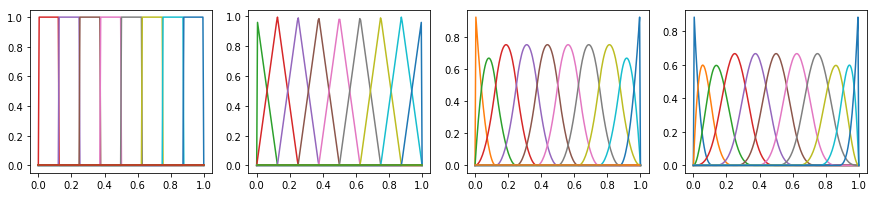

In [4]:
t = np.r_[0, 0, 0, np.linspace(0, 1, 9), 1, 1, 1]
x, B = spline_basis(t, 200, 3)
plot_basis(x, B, (1, 4), figsize=(15, 3))

上面B样条基的节点`t`的数值如下：

In [5]:
t

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.125,  0.25 ,  0.375,  0.5  ,
        0.625,  0.75 ,  0.875,  1.   ,  1.   ,  1.   ,  1.   ])

计算B样条基与控制点`p`的乘积和得到B样条曲线。三次B样条曲线的控制点数比节点数少4个元素。

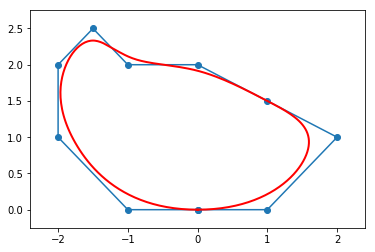

In [6]:
def spline_curve(B, k, p):
    return np.dot(np.column_stack([B[i, k] for i, _k in B if _k == k]), p)

p = np.array([[0, 0], [1, 0], [2, 1], [1, 1.5], [0, 2], [-1, 2], [-1.5, 2.5], [-2, 2], [-2, 1], [-1, 0], [0, 0]])
p2 = spline_curve(B, 3, p)
pl.plot(p[:, 0], p[:, 1], "-o")
pl.plot(p2[:, 0], p2[:, 1], "r", lw=2)
pl.margins(0.1, 0.1)

## B样条插值

`scipy.interpolate`提供了B样条曲线类和B样条插值的函数。`BSpline(t, c, k)`创建B样条曲线对象，其中`t`为节点，长度为`n+k+1`；`c`为控制点，长度为`n`；`k`为曲线的次数。直接调用B样条曲线可以计算与`t`对应的曲线上的点。下面计算的曲线与前面通过B样条基计算的结果相同。

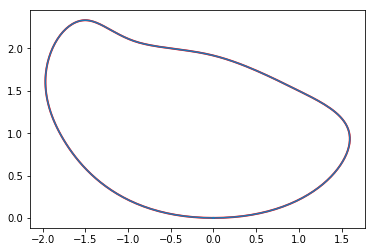

In [10]:
from scipy import interpolate

def plot_bspline(t, x, y, ax=None):
    line = interpolate.BSpline(t, np.c_[x, y], 3)
    if ax is None:
        fig, ax = pl.subplots()
    x, y = line(np.linspace(0, 1, 200)).T
    ax.plot(x, y)

line = interpolate.BSpline(t, p, 3)
x, y = line(np.linspace(0, 1, 200)).T
pl.plot(p2[:, 0], p2[:, 1], "r", lw=2)
pl.plot(x, y);

`make_interp_spline(t, p)`进行B样条插值。其中`t`为自变量，`p`为因变量。对于二维曲线，`p`是一个形状为`(N, 2)`的数组，保存$x(t), y(t)$的值。通常我们不知道`t`的时候，可以使用一个范围为0到1的等差数列。

In [29]:
def plot_interp_bspline(x, y, ax=None, **kw):
    line = interpolate.make_interp_spline(np.linspace(0, 1, len(x)), np.c_[x, y])
    x2, y2 = line(np.linspace(0, 1, 1000)).T
    if ax is None:
        fig, ax = pl.subplots()
    ax.plot(x, y, "x")
    ax.plot(x2, y2, **kw)
    xc, yc = line.c.T
    ax.plot(xc, yc, "o", alpha=0.5)
    return line

下面绘制B样条曲线，其中叉点为插值点，圆点为B样条曲线的控制点。

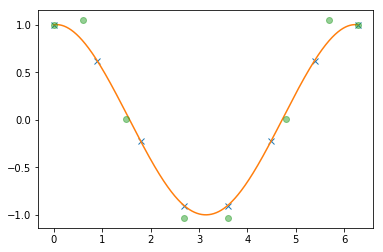

In [30]:
x = np.linspace(0, 2*np.pi, 8)
y = np.cos(x)
plot_interp_bspline(x, y);

下面是通过参数方程计算的插值点及与其对应的插值曲线。

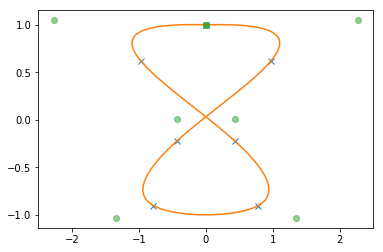

In [31]:
r = np.linspace(0, 2*np.pi, 8)
x = np.sin(2 * r)
y = np.cos(r)
plot_interp_bspline(x, y);

## Bezier曲线

Bezier曲线是一种参数曲线，三次Bezier曲线由四个点P0、P1、P2、P3决定。曲线起始于P0走向P1，并从P2的方向来到P3。

曲线的参数形式为：

$${\mathbf  {B}}(t)={\mathbf  {P}}_{0}(1-t)^{3}+3{\mathbf  {P}}_{1}t(1-t)^{2}+3{\mathbf  {P}}_{2}t^{2}(1-t)+{\mathbf  {P}}_{3}t^{3}{\mbox{ , }}t\in [0,1]$$

大多数的绘图软件都使用它描绘曲线轮廓。

`matplotlib`中的`Path`对象可以使用`CURVE4`节点类型绘制Bezier曲线。例如下面的曲线的四个点的坐标与其对应的节点类型分别为：

```
(0, 0) MOVETO
(0, 1) CURVE4
(1, 1) CURVE4
(1, 0) CURVE4
```

Bezier曲线可以转换为B样条曲线。只需要将其节点设置为`0, 0, 0, 0, 1, 1, 1, 1`，控制点设置为Bezier曲线的$P_0, P_1, P_2, P_3$即可。在下图中黑色粗线是使用`Path`绘制的Bezier曲线，而红色细线则是使用`BSpline`类计算的B样条曲线。

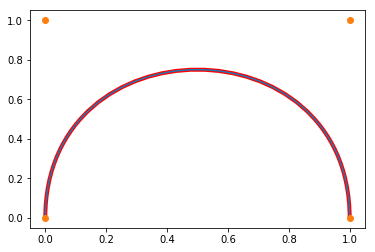

In [32]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def plot_bezier_path(x, y, ax=None, **kw):
    points = np.c_[x, y]
    p = Path(points, [Path.MOVETO] + [Path.CURVE4] * (len(points) - 1))
    patch = PathPatch(p, **kw)
    if ax is None:
        fig, ax = pl.subplots()        
    ax.add_patch(patch)
    ax.autoscale_view()
    
fig, ax = pl.subplots()
x = [0, 0, 1, 1]
y = [0, 1, 1, 0]
plot_bezier_path(x, y, ax=ax, fill=False, lw=4, color="red")
plot_bspline([0, 0, 0, 0, 1, 1, 1, 1], x, y, ax=ax)
ax.plot(x, y, 'o');

## 将BSpline转换为多段Bezier曲线

绘图软件中通常可以绘制多条连续的Bezier曲线。下面的`bspline_to_bezier()`将`BSpline`对象转换为绘制多条连续Bezier曲线的`Path`对线。它使用`interpolate.inert()`在B样条曲线曲线中插入重复的节点。`insert()`可以任意插入节点而保持曲线形状不变。

In [33]:
def bspline_to_bezier(line):
    new_line = line
    for t in line.t[4:-4]:
        new_line = interpolate.insert(t, new_line, m=3)
    points = new_line.c
    points = np.delete(points, np.arange(4, len(points), 4), axis=0)
    path = Path(points, [Path.MOVETO] + [Path.CURVE4] * (len(points) - 1))
    return path

下面先计算插值B样条曲线，然后将该曲线转换为`Path`对象。并使用`PathPatch`绘制填充部分。

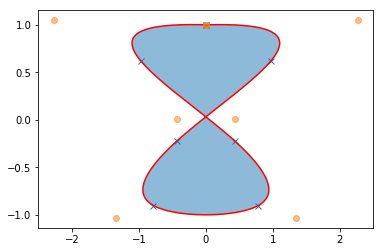

In [34]:
r = np.linspace(0, 2*np.pi, 8)
x = np.sin(2 * r)
y = np.cos(r)

fig, ax = pl.subplots()

line = plot_interp_bspline(x, y, ax=ax, color="red")
path = bspline_to_bezier(line)
patch = PathPatch(path, fill=True, linewidth=0, alpha=0.5)
ax.add_patch(patch);